In [88]:
# Get all required packages
import ee
# from osgeo import gdal
# from pyproj import CRS
# import geemap as gm

import rioxarray as rio
import xarray as xr
import pandas as pd

In [ ]:
# Setup for Earth Engine
# ee.Authenticate()
ee.Initialize()

### Load data for analysis

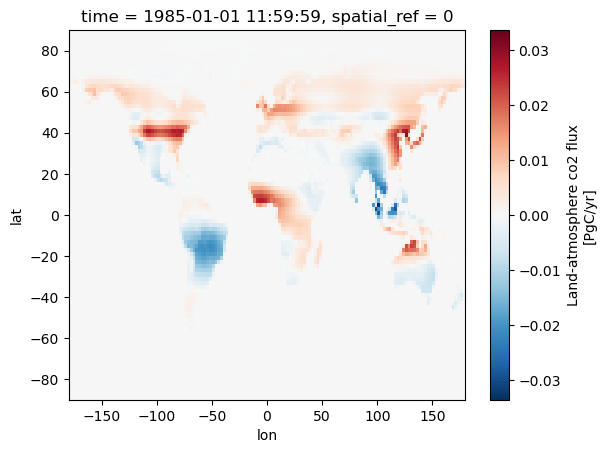

In [105]:
# Open data with Gdal and get the CRS information
# file_path = '/Users/moyanofe/BigData/GeoSpatial/Carboscope/Inversions/s85oc_v2022_daily.tiff'
file_path = '/Users/moyanofe/BigData/GeoSpatial/Carboscope/Inversions/s85oc_v2022_daily.nc'

# All three file reading methods read in the attributes differently.
# inv_co2 = rio.open_rasterio(file_path)
# inv_co2 = xr.open_dataset(file_path, engine="rasterio", variable='co2flux_land')
inv_co2 = rio.open_rasterio(file_path, variable='co2flux_land')
inv_co2 = inv_co2['co2flux_land']
inv_co2 = inv_co2.rename({'mtime': 'time'})  # Rename the time dimension and coordinate to something standard.
inv_co2 = inv_co2.rename({'x': 'lon'})  # Rename the time dimension and coordinate to something standard.
inv_co2 = inv_co2.rename({'y': 'lat'})  # Rename the time dimension and coordinate to something standard.
inv_co2.attrs['units'] = 'PgC/yr'  # For some reason the units is a tuple of repeating values. Replacing with single value.
inv_co2[0].plot()
# inv_co2 = inv_co2.reindex({'lat':inv_co2.lat[::-1]})  # Reindexing not necessary. Did open rasterio 
# rasplot.show(inv_co2[0])


### After loading data, we need to preprocess it to get it ready for analysis

#### Set the datetime properties

In [20]:

# The data is missing datetime information. Let's add it here:
times = pd.date_range(start="1985-01-01", end='2021-12-31', )


13514
13514


In [21]:
type(times)

pandas.core.indexes.datetimes.DatetimeIndex

#### Apply same crs to all data

Let's use the common WGS84: EPSG 4326. This should be set to all rasters used. If the crs was WGS84 but the property was not set, thenn use:  
`mydata.rio.write_crs("epsg:4326", inplace=True)`  

Else, change the crs with   
`mydata.rio.reproject("EPSG:4326")`  

When adding more datasets, these can be adjusted to the first using:  
`mydata2 = mydata2.rio.reproject_match(mydata)`  



#### Set a missing data value

Set a missing data value to be same across all data, e.g. -9999.   

`mydata.rio.set_nodata(-9999, inplace=True)` # will set the nadata attrribute without modifying the data
`mydata.rio.write_nodata(-9999, inplace=True)` # will write to the array (I guess replacing the existing missing data value?) Need to test.  

Note that the reproject_match method from above will modify the nodata value of mydata2 to match that of mydata.  

Use the following to mask the missing data:  
```
nodata = raster.rio.nodata
raster = raster.where(raster != nodata)
raster.rio.write_nodata(nodata, encoded=True, inplace=True)
```


#### 3. Create geometry objects to mask/filter the data, e.g. continents, above 50N, ecoregions

/Users/moyanofe/miniconda3/envs/landcover/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/Users/moyanofe/miniconda3/envs/landcover/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


<AxesSubplot:>

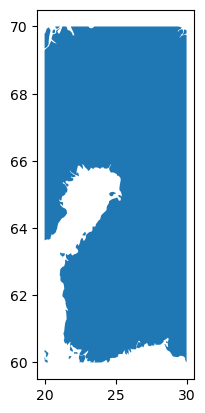

In [5]:
import geopandas as gpd
from shapely.geometry import box

conts_file = '/Users/moyanofe/Work/Augsburg/Research/LandCover/data/continents.geojson'
north50_file = '/Users/moyanofe/Work/Augsburg/Research/LandCover/data/north50.geojson'
testrect_file = '/Users/moyanofe/Work/Augsburg/Research/LandCover/data/testrect.geojson'

conts = gpd.read_file(conts_file)
north50 = gpd.read_file(north50_file)
testrect = gpd.read_file(testrect_file)
conts_north50 = conts.clip(north50)
testarea = conts.clip(testrect)
# print(conts.crs)
# print(north50.crs)
# conts.plot()
# north50.plot()
testarea.plot()
# conts_north50.plot()

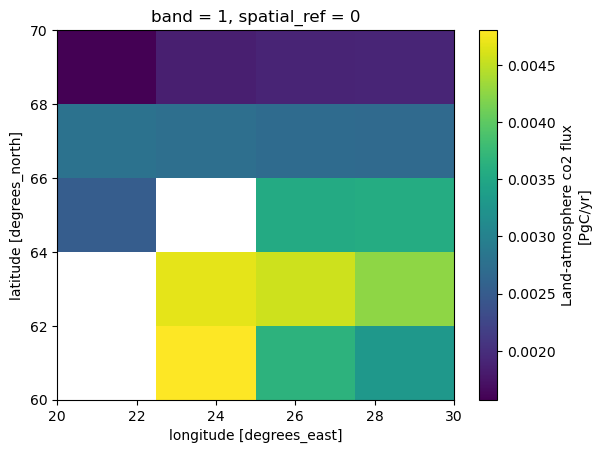

In [14]:
# Clipping only for the test area
inv_co2_test = inv_co2.rio.clip(testarea.geometry, testarea.crs)
# plot to check the output
inv_co2_test[0].plot()

### CO2 flux analysis

*Do the easy approach first, selecting for months and not fitting a harmonic:*
- Loop over years
- Per year choose growing season months
- Get the flux sum
- Repeat for the non winter months
- Get the difference between both and store as raster

In [ ]:
inv_co2_test
